# Deep GP supervised learning

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import mlai
import deepgp
import GPy
import teaching_plots as plot 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from pylab import *
from IPython.display import display
from gp_tutorial import ax_default, meanplot, gpplot

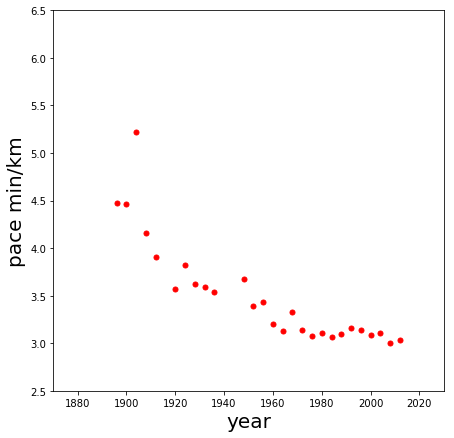

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_xlim((1870,2030))
ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/olympic-marathon.svg', transparent=True, frameon=True)


Perform a Gaussian process fit on the data using GPy.

In [3]:
m_full = GPy.models.GPRegression(x,y)
_ = m_full.optimize() # Optimize parameters of covariance function


 /Users/lawrennd/anaconda/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /Users/lawrennd/anaconda/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


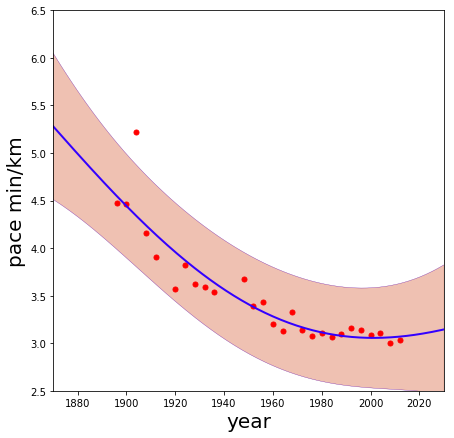

In [4]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
xt = np.linspace(1870,2030,200)[:,None]
yt = m_full.predict(xt)
_ = gpplot(xt,yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]), ax=ax)
ax.set_xlim((1870,2030))
ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/olympic-marathon-gp.svg', transparent=True, frameon=True)

Build a Deep GP with an additional hidden layer (one dimensional) to fit the model.

In [5]:
hidden = 1
m = deepgp.DeepGP([y.shape[1],hidden,x.shape[1]],Y=y, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)
m.obslayer.likelihood.variance[:] = y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)

Now optimize the model. Optimization is done in three stages, the first works on variational parameters and lengthscales only. The second also optimizes the kernel variance parameters, the final stages optimizes the entire model.

In [6]:
m.optimize(messages=False,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)

### Plot the prediction

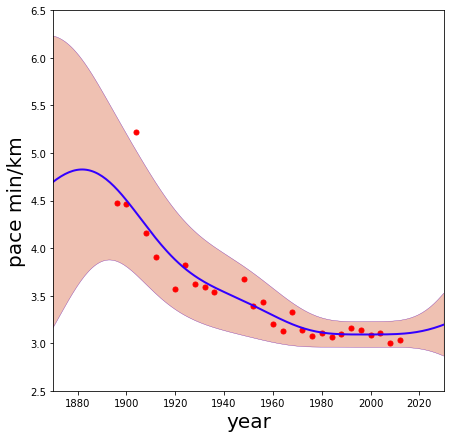

In [7]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('year', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
xt = np.linspace(1870,2030,200)[:,None]
yt = m.predict(xt)
_ = gpplot(xt,yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]), ax=ax)
ax.set_xlim((1870,2030))
ax.set_ylim((2.5,6.5))

plt.savefig('../../slides/diagrams/olympic-marathon-deep-gp.svg', transparent=True, frameon=True)

### Fitted GP for each layer

Now we explore the GPs the model has used to fit each layer. First of all, we look at the hidden layer.

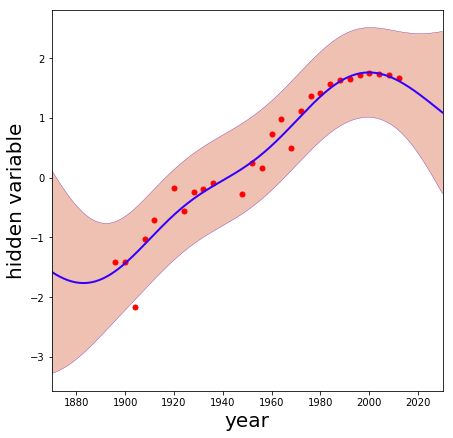

In [8]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, m.obslayer.X.mean, 'r.',markersize=10)
xt = np.linspace(1870,2030,200)[:,None]
yt = m.layer_1.predict(xt)
_ = gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]), ax=ax)
ax.set_ylabel('hidden variable', fontsize=20)
ax.set_xlabel('year', fontsize=20)
ax.set_xlim((1870,2030))
limx = ax.get_ylim()
plt.savefig('../../slides/diagrams/olympic-marathon-deep-gp-layer-1.svg', transparent=True, frameon=True)


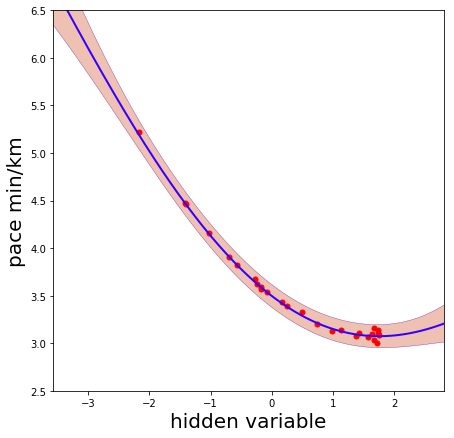

In [9]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.obslayer.X.mean, y, 'r.',markersize=10)
xt = np.linspace(limx[0]-0.1,limx[1]+0.1,200)[:,None]
yt = m.obslayer.predict(xt)
_ = gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]), ax=ax)
ax.set_xlabel('hidden variable', fontsize=20)
ax.set_ylabel('pace min/km', fontsize=20)
ax.set_ylim((2.5,6.5))
ax.set_xlim(limx)

plt.savefig('../../slides/diagrams/olympic-marathon-deep-gp-layer-2.svg', transparent=True, frameon=True)

### Robot Wireless Data

The robot wireless data is taken from an experiment run by Brian Ferris at University of Washington. It consists of the measurements of WiFi access point signal strengths as Brian walked in a loop.

In [13]:
data=GPy.util.datasets.robot_wireless()

x = np.linspace(0,1,215)[:, None]
y = data['Y']

The ground truth is recorded in the data, the actual loop is given in the plot below.

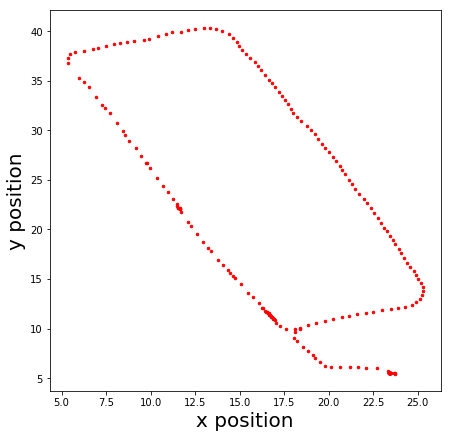

In [55]:
f, ax = plt.subplots(figsize=plot.big_figsize)
plt.plot(data['X'][:, 0], data['X'][:, 1], 'r.', markersize=5)
ax.set_xlabel('x position', fontsize=20)
ax.set_ylabel('y position', fontsize=20)
plt.savefig('../../slides/diagrams/robot-wireless-ground-truth.svg', transparent=True, frameon=True)

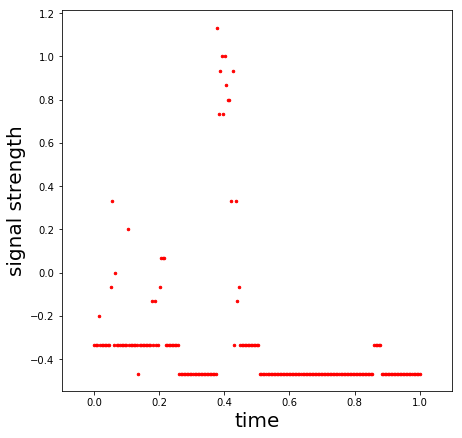

In [56]:
index = 12
xlim = (-0.1, 1.1)
f, ax = plt.subplots(figsize=plot.big_figsize)
_ = ax.plot(x, y[:, index:index+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_xlim(xlim)
ylim = ax.get_ylim()
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/robot-wireless-dim-' + str(index) + '.svg', transparent=True, frameon=True)

Perform a Gaussian process fit on the data using GPy.

In [57]:
m_full = GPy.models.GPRegression(x,y[:, index:index+1])
_ = m_full.optimize() # Optimize parameters of covariance function


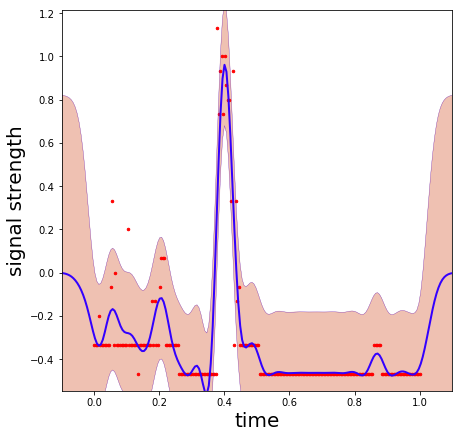

In [64]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y[:, index:index+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
xt = np.linspace(xlim[0], xlim[1],200)[:,None]
yt = m_full.predict(xt)
_ = gpplot(xt,yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]), ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/robot-wireless-gp-dim-' + str(index) + '.svg', transparent=True, frameon=True)

In [59]:
layers = [y.shape[1], 10, 5, 5, 2, x.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]

In [60]:
m = deepgp.DeepGP(layers,Y=y, X=x, inits=inits, 
                  kernels=kernels,
                  num_inducing=50, back_constraint=False)
m.obslayer.likelihood.variance[:] = y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)


In [61]:
m.optimize(messages=False,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=False,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=True,max_iters=10000)

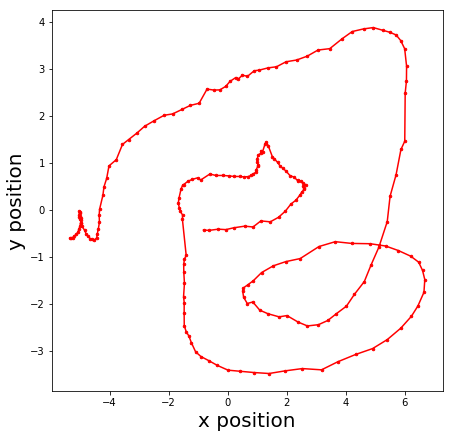

In [62]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(m.layers[-2].latent_space.mean[:, 0], m.layers[-2].latent_space.mean[:, 1], 'r.-', markersize=5)
ax.set_xlabel('x position', fontsize=20)
ax.set_ylabel('y position', fontsize=20)

plt.savefig('../../slides/diagrams/robot-wireless-latent-space.svg', transparent=True, frameon=True)

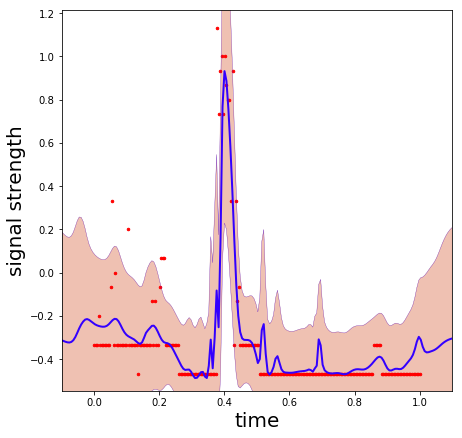

In [65]:
f, ax = plt.subplots(figsize=plot.big_figsize)
ax.plot(x, y[:, index:index+1], 'r.',markersize=5)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
xt = np.linspace(xlim[0],xlim[1],200)[:,None]
yt = m.predict(xt)
_ = gpplot(xt,yt[0][:, index:index+1],
           yt[0][:, index:index+1]-2*np.sqrt(yt[1][:, index:index+1]),
           yt[0][:, index:index+1]+2*np.sqrt(yt[1][:, index:index+1]), ax=ax)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('../../slides/diagrams/robot-wireless-deep-gp-dim-' + str(index) + '.svg', transparent=True, frameon=True)

In [ ]:
plt.plot(data['X'][:, 0], data['X'][:, 1])

In [ ]:
plt.plot(m.obslayer.latent_space.mean[:, 3],m.obslayer.latent_space.mean[:, 2])

In [ ]:
xt = np.linspace(-0.2,1.2,200)[:,None]
yt = m.predict(xt)

In [ ]:
yt[0]

In [ ]:
fig, ax = plt.subplots(3, 10, figsize=(10, 3))
for index in range(30):
    gpplot(xt,yt[0][:, index],
           yt[0][:, index]-2*np.sqrt(yt[1][:, index]),
           yt[0][:, index]+2*np.sqrt(yt[1][:, index]),
          ax=ax[index])
    #plot(x,y[:, index],'rx')
    xlabel('time')
    _=ylabel('strength')

# Step Function

In [ ]:
num_data= 50
x = np.linspace(-1, 1, num_data)[:, None]
y = (x>0) + np.random.randn(num_data, 1)*0.01

In [ ]:
plt.plot(x, y, 'r.')

In [ ]:
m = deepgp.DeepGP([y.shape[1], 1, 1, 1, 1, 1, 1, 1,x.shape[1]],Y=y, X=x, 
                  inits=['PCA','PCA', 'PCA', 'PCA', 'PCA', 'PCA', 'PCA', 'PCA'], 
                  kernels=[GPy.kern.RBF(1),GPy.kern.RBF(1),GPy.kern.RBF(1),GPy.kern.RBF(1),GPy.kern.RBF(1),
                           GPy.kern.RBF(1),GPy.kern.RBF(1),GPy.kern.RBF(x.shape[1])], # the kernels for each layer
                  num_inducing=20, back_constraint=False)
m.obslayer.likelihood.variance[:] = y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)
display(m)

In [ ]:
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=1000)

In [ ]:
xt = np.linspace(x.min()*2,x.max()*2,200)[:,None]
yt = m.predict(xt)
gpplot(xt,yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]))
plot(x,y,'rx')
xlabel('Year')
_=ylabel('Time given in pace (min per km)')

In [ ]:
yt = m.layer_1.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('input')
_=ylabel('hidden layer')


In [ ]:
yt = m.layer_2.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('hidden 1')
_=ylabel('hidden 2')

In [ ]:
yt = m.layer_3.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('hidden 2')
_=ylabel('hidden 3')

In [ ]:
yt = m.layer_4.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('hidden 3')
_=ylabel('hidden 4')

In [ ]:
yt = m.layer_5.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('hidden 4')
_=ylabel('hidden 5')